## <u>Optimisers</u>

When we train a deep learning model, the goal is to reduce the loss function (the error).
The optimizer is like a smart guide that tells the model how to update weights step by step to reduce error.

Think of it like:
*  You are climbing down a hill (loss surface).
*  The lowest point of the hill = minimum loss (best model).
*  Optimizer = the strategy you use to walk downhill.

---
<b><u>How Optimizers Work</u></b>

Optimizers decide:
*  Direction → which way to move the weights.
*  Step size (learning rate) → how big the step should be.

This is done using gradients (derivatives of the loss with respect to weights).

---
<b><u>Why Optimizers Matter</u></b>
*  Gradient Descent (GD) updates weights by following the steepest descent direction of the loss.
*  But plain GD can be slow, stuck in local minima, oscillate, and require manual learning rate tuning.
*  That’s why in practice we use advanced optimizers (SGD variants, Adam, RMSProp, etc.).

---
<b><u>Types of Optimizers</u></b>
1. <u>Gradient Descent (GD)</u>

Formula: $$\theta_{t+1} = \theta_t - \eta \,\nabla_\theta \mathcal{L}(\theta_t)
$$


Simple but slow. Looks at entire dataset each step.

---
2. <u>Stochastic Gradient Descent (SGD)</u>
$$g_t = \nabla_\theta \mathcal{L}_\mathcal{B}(\theta_t)
\qquad
\theta_{t+1} = \theta_t - \eta \, g_t
$$

*  Updates weights one sample at a time.
*  Faster, but noisy (steps bounce around).
*  Works better in practice than full GD.

---
3. <u>Mini-Batch Gradient Descent</u>

*  Middle ground: uses a small batch of samples each step.

Most common in Deep Learning.

---
4. <u>Momentum</u>
$$v_t = \beta v_{t-1} + (1-\beta)\, g_t
\qquad
\theta_{t+1} = \theta_t - \eta \, v_t
$$

*  Adds “memory” of past gradients.
*  Helps avoid getting stuck in small bumps.
*  Like pushing a ball downhill: it keeps rolling instead of stopping at small pits.

Formula:

---
5. <u>RMSProp</u>
$$r_t = \rho\, r_{t-1} + (1-\rho)\, (g_t \odot g_t)
\qquad
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{r_t} + \epsilon} \odot g_t
$$
*  Adapts learning rate for each parameter.
*  Divides gradient by running average of squared gradients.
*  Helps when gradients are very large/small.

Formula:

---
6. Adam (Adaptive Moment Estimation) 🚀 (Most Popular)

Combines Momentum + RMSProp.

Keeps track of:
*  Mean of gradients (momentum)
*  Variance of gradients (RMSProp)
*  Automatically adjusts learning rate for each parameter.

Formula (simplified):
$$m_t = \beta_1 m_{t-1} + (1-\beta_1)\, g_t
\qquad
v_t = \beta_2 v_{t-1} + (1-\beta_2)\, (g_t \odot g_t)
\\
\hat{m}_t = \frac{m_t}{1-\beta_1^t}
\qquad
\hat{v}_t = \frac{v_t}{1-\beta_2^t}
\qquad
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \odot \hat{m}_t
$$

---
🎯 In Short

*  GD: Too slow.
*  SGD: Faster, noisy.
*  Mini-batch: Best practical choice.
*  Momentum: Adds speed downhill.
*  RMSProp: Adjusts step size smartly.
*  Adam: Best of both worlds → fast, stable, widely used.

---
## ⚡ <u>Common Optimizers in PyTorch</u>
*  <b><u>Stochastic Gradient Descent (SGD)</u></b>

```python
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
```
➡  momentum helps smooth updates and escape local minima.

*  <b><u>Adam (Adaptive Moment Estimation)</b></u>

```python
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
```
➡ Most widely used; adapts learning rates per parameter.

*  <b><u> RMSProp</b></u>

```python
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
```
➡  Handles noisy data well, often used in RNNs.

---


Start with SGD → observe convergence.

Add Momentum → compare results.

Then switch to Adam → see faster convergence.

Optionally try RMSProp.

Compare training/validation curves (like the ones you plotted earlier).


Training with SGD...

Training with SGD+Momentum...

Training with Adam...

Training with RMSProp...


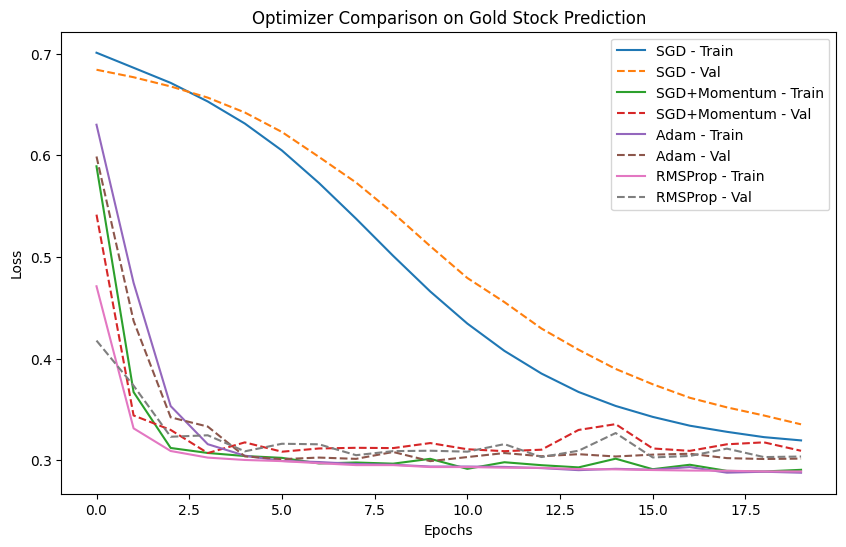

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# -------------------
# 1. Load dataset
# -------------------
df = pd.read_csv("goldstock.csv")

# Drop missing values (if any)
df.dropna(inplace=True)

# Feature Engineering
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
df['is_quarter_end'] = np.where(df['Date'].str.endswith(('03-31','06-30','09-30','12-31')),1,0)

# Target: 1 if Close rises next day else 0
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'open-close', 'low-high', 'is_quarter_end']
X = df[features].values
y = df['target'].values

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Datasets & loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# -------------------
# 2. Define Model
# -------------------
class StockNet(nn.Module):
    def __init__(self, input_dim):
        super(StockNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # Binary classification
        )
    def forward(self, x):
        return self.net(x)


# -------------------
# 3. Training Function
# -------------------
def train_model(optimizer_name, optimizer_class, **kwargs):
    model = StockNet(input_dim=X_train.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), **kwargs)

    train_losses = []
    val_losses = []

    for epoch in range(20):
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_losses.append(np.mean(batch_losses))

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_out = model(X_val_tensor)
            val_loss = criterion(val_out, y_val_tensor).item()
            val_losses.append(val_loss)

    return train_losses, val_losses


# -------------------
# 4. Train with different optimizers
# -------------------
optimizers = {
    "SGD": (optim.SGD, {"lr": 0.01}),
    "SGD+Momentum": (optim.SGD, {"lr": 0.01, "momentum": 0.9}),
    "Adam": (optim.Adam, {"lr": 0.001}),
    "RMSProp": (optim.RMSprop, {"lr": 0.001})
}

results = {}
for name, (opt_class, params) in optimizers.items():
    print(f"\nTraining with {name}...")
    train_losses, val_losses = train_model(name, opt_class, **params)
    results[name] = (train_losses, val_losses)


# -------------------
# 5. Plot results
# -------------------
plt.figure(figsize=(10,6))
for name, (train_losses, val_losses) in results.items():
    plt.plot(train_losses, label=f"{name} - Train")
    plt.plot(val_losses, linestyle="--", label=f"{name} - Val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Optimizer Comparison on Gold Stock Prediction")
plt.legend()
plt.show()
